In [18]:
import tensorflow as tf
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

In [19]:
# Abrir archivo
data = pd.read_csv('12_Serie_tiempo.csv', sep=';', decimal=',')
data = data.drop("fest", axis=1)
data.rename( columns={'Unnamed: 0':'ID'}, inplace=True )
# Elimina los valores muy bajos segun el rango inter cuartil
nan= np.nan
for column in data:
  if(data.dtypes[column] == float):
    Q1=np.percentile(data[column],25)
    Q3=np.percentile(data[column],75)
    r_inter_q = Q3-Q1
    umbralsup= Q3 + 1.5*r_inter_q
    umbralinf= Q1 - 1.5*r_inter_q
    for i in data[column]:
      if(i<=umbralinf):
        data[column] = data[column].replace([i], nan)
#    else if(i>=umbralsup):
#        data[column] = data[column].replace([i], nan)

#Establece valores eliminados por el promedio de sus vecinos
imputer = KNNImputer(n_neighbors=2, weights="uniform")
df1 = data.drop(columns=["ID", "Fecha", "Horas", "Agno", "Mes", "Dia_mes", "Dia_sem"])
data[df1.keys()]= imputer.fit_transform(df1)
data_modelo = pd.DataFrame(data, columns = ["Fecha", "Agno", "Mes","Horas","Dia_sem", "Dia_mes"])
data_modelo["Fecha"]=data_modelo["Fecha"].apply(lambda x:datetime.datetime.strptime(x, '%d-%m-%Y'))
data_modelo["Dia_ango"]=data_modelo["Fecha"].apply(lambda x: x.dayofyear)
data_modelo= data_modelo.drop(columns="Fecha")
data_modelo[df1.keys()]= data[df1.keys()]

In [20]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [21]:
i=0
# datatot=[]
#Asumo 13 horas en total en cada registro: 12 de entrada y 1 de salida.
datatot = np.empty((0,13))
for col in data_modelo.columns:
    i=i+1 
    # print(col)
    #Solo columnas numericas
    if i>6:
      #recover column of data
      a=data_modelo.iloc[:,i-1].to_numpy()
      a = np.expand_dims(a, axis=1)
      # print(type(a))
      # print(a.shape)
      b=series_to_supervised(a, n_in=12, n_out=1, dropnan=True)
      # print(b.shape)
      # datatot.append(b)
      # print("XXXXXXXX")
      datatot=np.vstack((datatot, b))
print(datatot.shape)

(321024, 13)


In [22]:
from sklearn.preprocessing import MinMaxScaler
#scaling by hour -> It suppose to be 
#el mismo rango para las 13 horas. Como sea si hubieran mas variables, hay que repensar normalizacion, posiblemente habria que usar otro metodo.
#https://stackoverflow.com/questions/55226959/normalize-a-multidimensional-array
scaler = MinMaxScaler(feature_range=(0, 1))
values = scaler.fit_transform(datatot)
#print(datatot.shape)
print(type(datatot))

<class 'numpy.ndarray'>


In [23]:
#Separate train/test
fils, nvars = values.shape
n_train_time = int(np.floor(fils*0.7)) #365*24
print(n_train_time)
train = values[:n_train_time, :]
test = values[n_train_time:, :]
print(train.shape)
print(test.shape)
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1],1))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1],1))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

224716
(224716, 13)
(96308, 13)
(224716, 12, 1) (224716,) (96308, 12, 1) (96308,)


In [24]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout
from keras.metrics import Accuracy
from keras import backend as K
from keras.layers import Bidirectional

In [25]:
from keras import backend as K

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [26]:
model = Sequential()
model.add(Bidirectional(LSTM(24, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]))))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(24, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(24)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[coeff_determination])

In [27]:
# fit network
history = model.fit(train_X, train_y, epochs=101, batch_size=64, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/101
3512/3512 - 31s - loss: 0.0142 - coeff_determination: -4.0056e-01 - val_loss: 0.0209 - val_coeff_determination: -9.6682e-01
Epoch 2/101
3512/3512 - 22s - loss: 0.0127 - coeff_determination: -1.7170e-01 - val_loss: 0.0192 - val_coeff_determination: -7.8285e-01
Epoch 3/101
3512/3512 - 22s - loss: 0.0123 - coeff_determination: -1.3201e-01 - val_loss: 0.0191 - val_coeff_determination: -7.8147e-01
Epoch 4/101
3512/3512 - 22s - loss: 0.0120 - coeff_determination: -1.0771e-01 - val_loss: 0.0193 - val_coeff_determination: -8.0313e-01
Epoch 5/101
3512/3512 - 22s - loss: 0.0118 - coeff_determination: -8.6746e-02 - val_loss: 0.0182 - val_coeff_determination: -6.7616e-01
Epoch 6/101
3512/3512 - 22s - loss: 0.0116 - coeff_determination: -7.4526e-02 - val_loss: 0.0176 - val_coeff_determination: -6.0770e-01
Epoch 7/101
3512/3512 - 22s - loss: 0.0115 - coeff_determination: -6.5310e-02 - val_loss: 0.0165 - val_coeff_determination: -4.7126e-01
Epoch 8/101
3512/3512 - 22s - loss: 0.0114 - coe

Epoch 61/101
3512/3512 - 22s - loss: 0.0107 - coeff_determination: 0.0029 - val_loss: 0.0142 - val_coeff_determination: -2.0389e-01
Epoch 62/101
3512/3512 - 22s - loss: 0.0107 - coeff_determination: 0.0022 - val_loss: 0.0141 - val_coeff_determination: -1.8649e-01
Epoch 63/101
3512/3512 - 22s - loss: 0.0107 - coeff_determination: 0.0013 - val_loss: 0.0142 - val_coeff_determination: -1.9315e-01
Epoch 64/101
3512/3512 - 22s - loss: 0.0107 - coeff_determination: 0.0030 - val_loss: 0.0143 - val_coeff_determination: -2.1207e-01
Epoch 65/101
3512/3512 - 22s - loss: 0.0107 - coeff_determination: 0.0010 - val_loss: 0.0143 - val_coeff_determination: -2.1009e-01
Epoch 66/101
3512/3512 - 22s - loss: 0.0107 - coeff_determination: 0.0030 - val_loss: 0.0142 - val_coeff_determination: -1.9339e-01
Epoch 67/101
3512/3512 - 22s - loss: 0.0107 - coeff_determination: 0.0024 - val_loss: 0.0142 - val_coeff_determination: -2.0090e-01
Epoch 68/101
3512/3512 - 22s - loss: 0.0107 - coeff_determination: 0.0023 - 

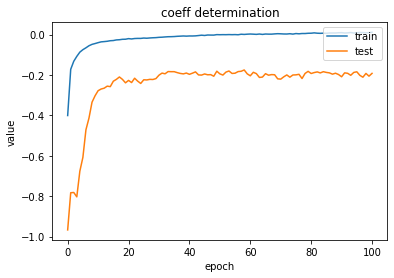

In [28]:
# summarize history for loss
plt.plot(history.history['coeff_determination'])
plt.plot(history.history['val_coeff_determination'])
plt.plot
plt.title('coeff determination')
plt.ylabel('value')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

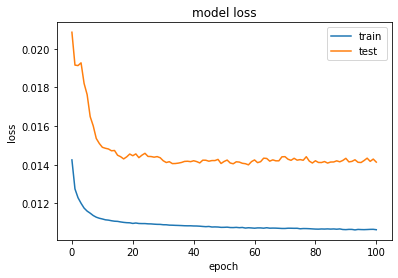

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [30]:
from sklearn.metrics import mean_squared_error,r2_score
# make a prediction
yhat = model.predict(test_X)
print(yhat.shape)
yhat = yhat.reshape(yhat.shape[0], yhat.shape[1])
test_X_ = test_X.reshape(test_X.shape[0],test_X.shape[1])
# invert scaling for forecast
print(test_X.shape)
inv_yhat = np.concatenate((yhat, test_X_), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
print(inv_yhat.shape)
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X_), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('RMSE: %.3f' % rmse)
# MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape= mean_absolute_percentage_error(inv_y, inv_yhat)
print('MAPE: %.3f' % mape)
print('R2AJ: %.3f' % history.history['val_coeff_determination'][-1])

(96308, 1)
(96308, 12, 1)
(96308,)
RMSE: 12.958
MAPE: 18.239
R2AJ: -0.192


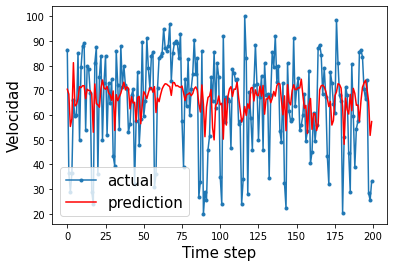

In [31]:
## time steps, every step is one hour (you can easily convert the time step to the actual time index)
## for a demonstration purpose, I only compare the predictions in 200 hours. 

aa=[x for x in range(200)]
plt.plot(aa, inv_y[:200], marker='.', label="actual")
plt.plot(aa, inv_yhat[:200], 'r', label="prediction")

plt.ylabel('Velocidad', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

In [32]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

tf.keras.backend.clear_session() 

In [33]:
model.save('LSTM_3_BD_24.h5')

In [34]:
#new_model = keras.models.load_model('modelo_prueba1.h5', custom_objects={ 'coeff_determination': coeff_determination})
